<a href="https://colab.research.google.com/github/joonseonyoon/CVAE/blob/master/DeepFrag_Demo%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepFrag Demo

This notebook contains examples of how to use a trained DeepFrag model to generate predictions.

## Download model and repo


In [ ]:
# Download fully trained DeepFrag model.
!wget -q -O model.zip -L https://durrantlab.pitt.edu/apps/deepfrag/files/final_model_v2.zip
!unzip -q model.zip

In [ ]:
# Download fragment fingerprints for inference.
!wget -q -O fingerprints.h5 -L https://durrantlab.pitt.edu/apps/deepfrag/files/fingerprints.h5

In [ ]:
# Clone DeepFrag python package.
!git clone https://git.durrantlab.pitt.edu/jdurrant/deepfrag.git

Cloning into 'deepfrag'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (449/449), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 449 (delta 244), reused 423 (delta 228), pack-reused 0
Receiving objects: 100% (449/449), 34.05 MiB | 25.96 MiB/s, done.
Resolving deltas: 100% (244/244), done.


In [ ]:
# Install rdkit and openbabel
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit=2020.03.5
!time conda install -q -y -c conda-forge openbabel

--2021-09-17 01:10:02--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2021-09-17 01:10:02--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   146MB/s    in 0.6s    

2021-09-17 01:10:03 (146 MB/s) - ‘Minicon

## Dependencies

In [ ]:
!pip3 -qqq install wandb prody py3Dmol

     |████████████████████████████████| 1.8MB 26.0MB/s 
     |████████████████████████████████| 6.3MB 18.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 133kB 48.0MB/s 
     |████████████████████████████████| 174kB 49.9MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 2.3MB 24.1MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 


In [ ]:
import sys
sys.path.append('./deepfrag')
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
!pip install prody


     |████████████████████████████████| 6.3 MB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
     |████████████████████████████████| 2.3 MB 36.9 MB/s 
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Created wheel for prody: filename=ProDy-2.0-cp37-cp37m-linux_x86_64.whl size=6708817 sha256=3c25065c2264ecfd7ee75bce37351cbd500c3f59e95733b82a8c625bb1655879
  Stored in directory: /root/.cache/pip/wheels/9f/cf/98/0221960cde47f24d8bd8be2ad62ba20b4c151b6e1dd8e27e82
Successfully built prody


In [ ]:
!pip install py3Dmol

In [ ]:
import torch
import prody
import py3Dmol
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
Draw.IPythonConsole.ipython_3d = True
import numpy as np
import time
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from leadopt.model_conf import LeadoptModel, DIST_FN
from leadopt import grid_util
from leadopt.data_util import REC_TYPER, LIG_TYPER
from leadopt import util

In [ ]:
def to2d(x):
  '''Remove 3d coordinate info from a rdkit mol for display purposes.'''
  return Chem.MolFromSmiles(Chem.MolToSmiles(x, isomericSmiles=False))

def tosdf(x):
  '''Rdkit mol to SDF string.'''
  return Chem.MolToMolBlock(x)+'$$$$\n'

## Step 0: Preprocess structure data

We are using an example from RCSB. We obtain a `pdb1` file and we need to separate the receptor and ligand into separate files. In this step, we will also remove water molecules.

In [ ]:
# Ensure our example is in the TEST set (i.e. not seen during training or validation)
from config import moad_partitions
"2XP9" in moad_partitions.TEST

True

In [ ]:
# Download the ligand/receptor complex from RCSB.
!wget -L https://files.rcsb.org/download/2XP9.pdb1.gz
!gzip -df 2XP9.pdb1.gz

--2021-09-17 01:16:24--  https://files.rcsb.org/download/2XP9.pdb1.gz
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.234
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29471 (29K) [application/octet-stream]
Saving to: ‘2XP9.pdb1.gz’

2XP9.pdb1.gz        100%[===================>]  28.78K  --.-KB/s    in 0.05s   

2021-09-17 01:16:24 (557 KB/s) - ‘2XP9.pdb1.gz’ saved [29471/29471]



In [ ]:
# Use ProDy to split the complex into separate protein and ligand pdb files.
m = prody.parsePDB('./2XP9.pdb1')
rec = m.select('not (nucleic or hetatm) and not water')
lig = m.select('resname 4G8')

prody.writePDB('./rec.pdb', rec)
prody.writePDB('./lig.pdb', lig)

@> 1337 atoms and 1 coordinate set(s) were parsed in 0.02s.


'./lig.pdb'

In [ ]:
# We need to use OpenBabel to infer bond order information since RDKit doesn't.
!obabel lig.pdb -Olig.sdf

1 molecule converted


## Step 1: Load receptor and convert to coordinates and types

In this step we extract relevant atomic information from the receptor pdb file. Specifically, we need to generate a numpy array of atomic coordinates (x,y,z) and atomic "types". By default, this package uses a descriptive format for "types" including the atomc number, boolean indicators for aromaticity, hydrogen acceptor/donor and an unsigned char representation of the partial charge.

However, the final model uses the `simple` type scheme which only requires the atomic number. So we could simply extract the atomic number here and use a different `rec_typer` later on.

In [ ]:
rec_coords, rec_types = util.load_receptor_ob('./rec.pdb')

print('Coords (x,y,z):\n', rec_coords[:5])
print('Types (element, aro, hdon, hacc, charge):\n', rec_types[:5])

Coords (x,y,z):
 [[ 30.027 -43.712  23.321]
 [ 29.581 -42.797  22.203]
 [ 30.82  -42.096  21.671]
 [ 31.816 -41.97   22.388]
 [ 28.554 -41.759  22.695]]
Types (element, aro, hdon, hacc, charge):
 [[7. 0. 0. 0. 0.]
 [6. 0. 0. 0. 0.]
 [6. 0. 0. 0. 0.]
 [8. 0. 0. 0. 0.]
 [6. 0. 0. 0. 0.]]


## Step 2: Load ligand and generate fragments

Next we will load the ligand from the pdb file and generate a list of `(parent, fragment)` tuples.

Generated 10 fragments


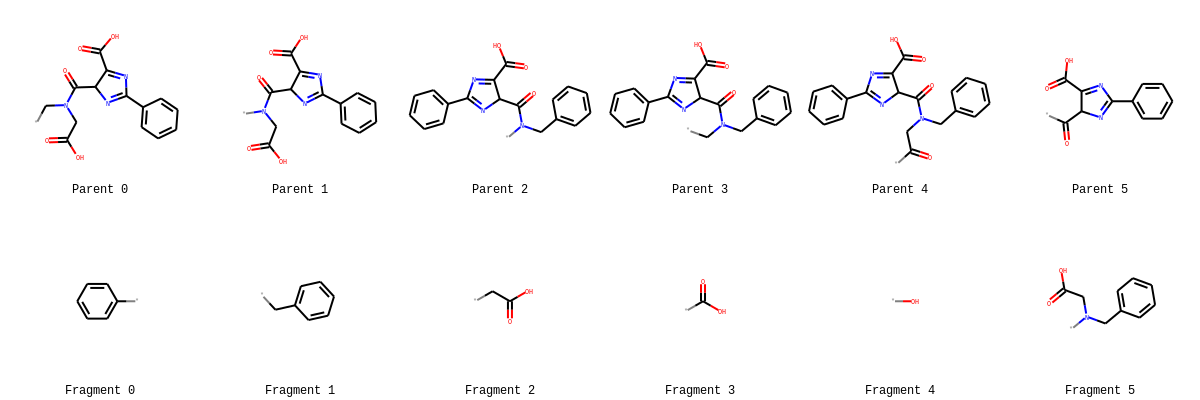

In [ ]:
from rdkit.Chem import rdmolops

lig = Chem.MolFromMolFile('./lig.sdf')
ligs = rdmolops.GetMolFrags(lig, asMols = True)
lig = max(ligs, default=lig, key=lambda m: m.GetNumAtoms())

frags = util.generate_fragments(lig)

print('Generated %d fragments' % len(frags))

NUM = 6
Draw.MolsToGridImage(
    [to2d(x[0]) for x in frags[:NUM]] + [to2d(x[1]) for x in frags[:NUM]],
    legends=(
        ['Parent %d' % x for x in range(NUM)] 
        + ['Fragment %d' % x for x in range(NUM)]
    ),
    molsPerRow=NUM)

In [ ]:
# Change this to select a different fragment.
FRAG_IDX = 9

view = py3Dmol.view(width=800, height=800)

# Receptor.
view.addModel(open('./rec.pdb', 'r').read(), 'pdb')
view.setStyle({'model': 0}, {'cartoon': {'color':'spectrum'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'})

# Parent.
view.addModel(tosdf(frags[FRAG_IDX][0]), 'sdf')
view.setStyle({'model': 1}, {'stick':{}})

# Fragment.
view.addModel(tosdf(frags[FRAG_IDX][1]), 'sdf')
view.setStyle({'model': 2}, {'stick':{'color': 'yellow'}})

view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In this mode of operation, we will ask DeepFrag to predict a suitable replacement for the fragment above (highlighted in yellow). The network input will consist of the local receptor context and the "parent" molecule (the part of the ligand that is not the fragment).

## Step 3: Convert parent to coordinates and types

Like the receptor, we need to convert the parent portion of the ligand to an array of coordinates and types. Here we will also identify the "connection point" to use for fragment prediction. During training, the connection point is simply the atom on the parent ligand that the fragment is connected to. We provide a utility method to identify this by searching for the rdkit dummy atom type 0.

In [ ]:
parent = frags[FRAG_IDX][0]

parent_coords = util.get_coords(parent)
parent_types = np.array(util.get_types(parent)).reshape((-1,1))
conn = util.get_connection_point(frags[FRAG_IDX][1])

print('Coords (x,y,z):\n', parent_coords[:5])
print('Types (element):\n', parent_types[:5])
print('Connection point: ', conn)

Coords (x,y,z):
 [[ 44.196 -12.488  15.223]
 [ 44.932 -13.377  16.027]
 [ 44.238 -14.388  16.728]
 [ 42.835 -14.494  16.633]
 [ 42.104 -13.608  15.831]]
Types (element):
 [[6]
 [6]
 [6]
 [6]
 [6]]
Connection point:  [ 38.935 -15.692  11.454]


## Step 4: Load DeepFrag Model & Fingerprints

We can load a pretrained DeepFrag model with `LeadoptModel.load`. This function expects a path to a model folder which contains `args.json` describing the model hyperparameters and `voxel.pt` containing the serialized weights of the model.

By default, this model will be loaded on the GPU, however we can pass a PyTorch device to the `device` parameter to load the model on the CPU instead.

In [ ]:
USE_CPU = True

device = torch.device('cpu') if USE_CPU else torch.device('cuda')
print('Using CPU' if USE_CPU else 'Using GPU')

model = LeadoptModel.load('./final_model', device=device)

with h5py.File('./fingerprints.h5', 'r') as f:
  f_smiles = f['smiles'][()]
  f_fingerprints = f['fingerprints'][()].astype(np.float)

print('Loaded %d fingerprints' % len(f_smiles))

Using CPU
Loaded 5564 fingerprints


### Note: Training-serving skew

To ensure the same configuration is used during training and inference, model hypeparameters are bundled with each model. This includes train-time constants such as learning rate and model architecture however it also includes grid generation parameters. These parameters are accessable through the `model._args` dict. This system enables model reflection and you can write scripts that look up configuration parameters at runtime. For example, in the cells below, we lookup grid generation parameters from the saved model to configure how to generate new grids at inference time.

In [ ]:
for k in model._args:
  print('%s:' % k, model._args[k])

version: voxelnet
no_partitions: False
fragments: ./data/moad.h5
fingerprints: ./data/rdk10_moad.h5
learning_rate: 0.0001
num_epochs: 1000
test_steps: 400
batch_size: 16
grid_width: 24
grid_res: 0.75
fdist_min: None
fdist_max: 4
fmass_min: None
fmass_max: 150
ignore_receptor: False
ignore_parent: False
output_size: 2048
pad: False
blocks: [64, 64]
fc: [512]
use_all_labels: True
dist_fn: cos
loss: direct
point_radius: 1.75
point_type: 0
rec_typer: simple
acc_type: 0
lig_typer: simple


## Step 5: Generate Voxel Grids

Now we can generate grids. The grid generation code is implemented with Numba, a JIT CUDA compiler for Python. The first grid generation step may be slower as Numba needs to compile the CUDA kernel. Subsequent steps will be faster as the kernel can be reused. 

In [ ]:
start = time.time()
batch = grid_util.get_raw_batch(
    rec_coords, rec_types, parent_coords, parent_types,
    rec_typer=REC_TYPER[model._args['rec_typer']],
    lig_typer=LIG_TYPER[model._args['lig_typer']],
    conn=conn,
    num_samples=32,
    width=model._args['grid_width'],
    res=model._args['grid_res'],
    point_radius=model._args['point_radius'],
    point_type=model._args['point_type'],
    acc_type=model._args['acc_type'],
    cpu=USE_CPU
)
batch = torch.as_tensor(batch)
end = time.time()

print('Shape: ', batch.shape)
print('Batch generated in %0.3f seconds' % (end - start))

Shape:  torch.Size([32, 9, 24, 24, 24])
Batch generated in 18.864 seconds


## (optional) visualize the grids

Here we plot one grid from the batch of 32. Each image in the figure below is a `width x width` slice of atomic density information. Each row represents a different `channel`. Each column represents a different `x` position.

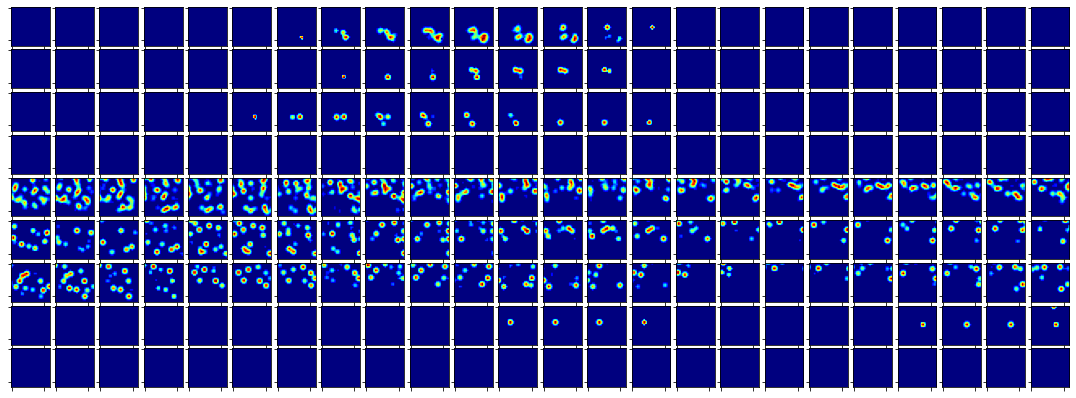

In [ ]:
batch_n = batch.cpu().numpy()

IDX = 0
SCALE = 0.8

NLAYER = batch_n.shape[1]
NWIDTH = batch_n.shape[2]

plt.figure(figsize=(int(NWIDTH * SCALE), int(NLAYER * SCALE)))
for layer in range(NLAYER):
  for x in range(NWIDTH):
    ax = plt.subplot(NLAYER, NWIDTH, (layer * NWIDTH) + x + 1)
    plt.imshow(batch_n[IDX][layer][x], cmap='jet')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Step 6: Generate Predictions

We feed the voxel tensor to the model to obtain a prediction vector.

The voxel input is 5 dimensional with dimensions: (batch_idx, layer_idx, x, y, z).

In [ ]:
start = time.time()
pred = model.predict(batch.float()).cpu().numpy()
end = time.time()

print('Generated prediction in %0.3f seconds' % (end - start))
print('Shape:', pred.shape)

Generated prediction in 2.474 seconds
Shape: (32, 2048)


## (optional) visualize a prediction fingerprint

We can plot the fingerprint values as an image. This is fairly hard to interpret without comparing to other fingerprints.

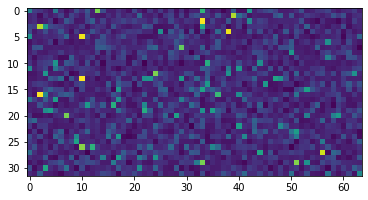

In [ ]:
IDX = 0
fp = pred[IDX].reshape((32, 64))

plt.imshow(fp)

## Step 7: Compare to Fingerprint Library

To make sense of this generated fingerprint, we need to compare it to a fingerprint library.

Average FP shape: (2048,)
Top 16 fragments:


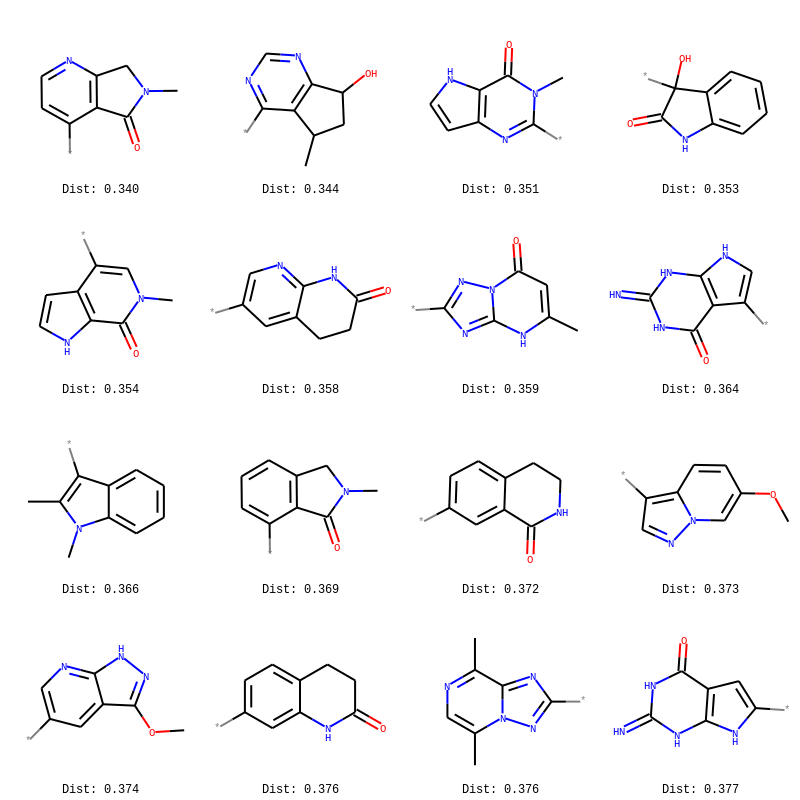

In [ ]:
# Compute the average fingerprint.
avg_fp = np.mean(pred, axis=0)
print('Average FP shape:', avg_fp.shape)

# Grab the model distance function (in this case, cosine similarity).
dist_fn = DIST_FN[model._args['dist_fn']]

# The distance functions are implemented in pytorch so we need to convert our
# numpy arrays to a torch Tensor.
dist = dist_fn(
    torch.Tensor(avg_fp).unsqueeze(0),
    torch.Tensor(f_fingerprints))

# Pair smiles strings and distances.
dist = list(dist.numpy())
scores = list(zip(f_smiles, dist))
scores = sorted(scores, key=lambda x:x[1])

print('Top 16 fragments:')

mols = [Chem.MolFromSmiles(x[0]) for x in scores[:16]]
leg = ['Dist: %0.3f' % x[1] for x in scores[:16]]
Draw.MolsToGridImage(mols, molsPerRow=4, legends=leg)

# Step 8 (optional): Generate 3D embedding

In this step we will sample several conformations of the predicted ligand and visualize how it fits in the receptor pocket.

## Rdkit Utility Code

In [ ]:
def geometric_embedding(fragment):
  """Generate a realistic 3D embedding of a fragment.

  Note: this method strictly optimizes the fragment conformation without respect
  to the receptor or parent molecule. For small fragments, the conformation will
  already be fairly fixed so this probably won't do much.
  
  Args:
  - fragment: rdkit molecule

  Returns:
  - an rdkit molecule with 3D coordinates
  """
  frag = to2d(fragment)

  # Temporarily replace dummy atoms with hydrogen so we get reasonable geometry.
  dummy_idx = [x.GetIdx() for x in fragment.GetAtoms() if x.GetAtomicNum() == 0]
  for idx in dummy_idx:
    frag.GetAtomWithIdx(idx).SetAtomicNum(1)

  # Minimize engergy.
  frag = Chem.AddHs(frag)
  cids = AllChem.EmbedMultipleConfs(frag, 50, pruneRmsThresh=1)
  for conf in cids:
    AllChem.UFFOptimizeMolecule(frag, confId=conf, maxIters=200)

  # Replace any dummy atoms.
  for idx in dummy_idx:
    frag.GetAtomWithIdx(idx).SetAtomicNum(0)

  return frag, cids

def get_connecting_atoms(mol):
  """Return the connection point atom (element 0), it's neighbor,
  and a neighbor of the neighbor (for defining dihedral)."""
  connectidx = [a.GetIdx() for a in mol.GetAtoms() if a.GetAtomicNum() == 0][0]
  atm = mol.GetAtomWithIdx(connectidx)
  nextatm = atm.GetNeighbors()[0]
  nextidx = nextatm.GetIdx()
  nextnextidx = [a for a in nextatm.GetNeighbors() if a.GetIdx() != connectidx][0].GetIdx()
  return connectidx, nextidx, nextnextidx

def embed_fragment(rec, parent, fragment):
  """Generate an embedding of the (parent/fragment) fusion molecule in the 
  context of a receptor.

  Args:
  - rec: An rdkit mol containing the receptor complex.
  - parent: An rdkit mol containing the parent molecule.
  - fragment: An rdkit mol containing the fragment molecule that should be
    attached to the parent.

  Returns:
  (ligand, energies, best_energy)

  - ligand: The optimized parent/fragment ligand as an rdkit mol.
  - energies: A list of predicted energies from sampling different conformations.
  - best_energy: The lowest energy from the sampled conformations.
  """
  energies = []

  Chem.SanitizeMol(rec)
  fragment, cids = geometric_embedding(fragment)

  # Find the dihedral
  paridx, parnext, parnextnext = get_connecting_atoms(parent)
  
  best_energy = np.inf
  best_mol = None

  # For each conformer...
  for cid in tqdm(cids, desc='Sampling conformations'):
    mol = Chem.RWMol(fragment, False, cid)

    # Align the connection point.
    fragidx, fragnext, fragnextnext = get_connecting_atoms(mol)
    Chem.rdMolAlign.AlignMol(
        mol, parent, atomMap=[(fragidx,parnext),(fragnext,paridx)])

    # Merge into new molecule.
    merged = Chem.RWMol(Chem.CombineMols(parent,mol))

    # Update fragment indices.
    fragidx += parent.GetNumAtoms()
    fragnext += parent.GetNumAtoms()
    fragnextnext += parent.GetNumAtoms()
    bond = merged.AddBond(parnext,fragnext,Chem.rdchem.BondType.SINGLE)
    merged.RemoveAtom(fragidx)
    merged.RemoveAtom(paridx)
    Chem.SanitizeMol(merged)

    # Update indices to account for deleted atoms.
    if fragnext > fragidx: fragnext -= 1
    if fragnextnext > fragidx: fragnextnext -= 1
    fragnext -= 1
    fragnextnext -= 1
    if parnext > paridx: parnext -= 1
    if parnextnext > paridx: parnextnext -= 1

    # Optimize the connection of the fragment (bond is wrong length).
    ff = AllChem.UFFGetMoleculeForceField(merged)
    for p in range(parent.GetNumAtoms()-1): # Don't include dummy atom.
      ff.AddFixedPoint(p) # Don't move parent.
    ff.Minimize()

    # Create a complex with the receptor.
    reclig = Chem.CombineMols(rec, merged)
    Chem.SanitizeMol(reclig)

    # Determine dihedral indices.
    l = fragnextnext+rec.GetNumAtoms()
    k = fragnext+rec.GetNumAtoms()
    j = parnext+rec.GetNumAtoms()
    i = parnextnext+rec.GetNumAtoms()

    # Sample the dihedral.
    for deg in tqdm(range(0,360,5), desc='Sampling dihedral angle'):
      Chem.rdMolTransforms.SetDihedralDeg(reclig.GetConformer(),i,j,k,l,deg)

      # Create forcefield for the whole complex.
      ff = AllChem.UFFGetMoleculeForceField(reclig,ignoreInterfragInteractions=False)

      # Fix everything but the fragment.
      for p in range(rec.GetNumAtoms()+parent.GetNumAtoms()-1):
        ff.AddFixedPoint(p)    
      energy = ff.CalcEnergy()

      energies.append(energy)
      if energy < best_energy:
        best_energy = energy
        best_mol = Chem.RWMol(reclig)

  # Extract the best ligand.
  ligatoms = set(range(rec.GetNumAtoms(), best_mol.GetNumAtoms()))
  ligbonds = [b.GetIdx() for b in best_mol.GetBonds() if b.GetBeginAtomIdx() in ligatoms and b.GetEndAtomIdx() in ligatoms]
  bestlig = Chem.PathToSubmol(best_mol, ligbonds)

  return bestlig, energies, best_energy

## Generate embeddings

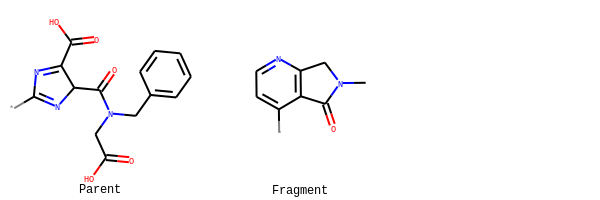

In [ ]:
rec = Chem.MolFromPDBFile('rec.pdb') # Load receptor into rdkit.
fragment = mols[0] # Pick the top-predicted fragment.

Draw.MolsToGridImage(
    [to2d(parent), to2d(fragment)],
    legends=['Parent', 'Fragment'])

Sampling conformations:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

(0.0, 10000.0)

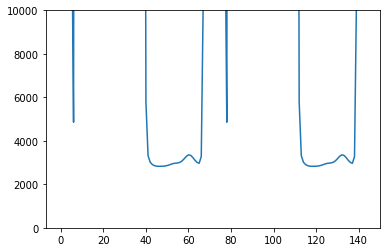

In [ ]:
lig, energies, best_energy = embed_fragment(rec, parent, fragment)

plt.plot(energies)
plt.ylim(0,10000)

We can visualize the embedding of the predicted fragment and compare it to the original fragment (in yellow).

In [ ]:
view = py3Dmol.view(width=800, height=800)

# Receptor.
view.addModel(Chem.MolToPDBBlock(rec), 'pdb')
view.setStyle({'model': 0}, {'cartoon': {'color':'spectrum'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'})

# Generated embedding.
view.addModel(tosdf(lig), 'sdf')
view.setStyle({'model': 1}, {'stick':{}})

# Original fragment.
view.addModel(tosdf(frags[FRAG_IDX][1]), 'sdf')
view.setStyle({'model': 2}, {'stick':{'color': 'yellow'}})

view.zoomTo({'model':1})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol